In [274]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(palette='Set2')
import plotly.graph_objects as go

from scipy.stats import norm

from datetime import timedelta
from pandas import Timestamp

from sklearn.mixture import GaussianMixture

from typing import Tuple

import warnings
warnings.filterwarnings('ignore')

import nbimporter

## Auxilary Functions

In [82]:
def avg_active_signals_(signals: pd.DataFrame, molecule: np.ndarray) -> pd.Series:
    '''
    Auxilary function for averaging signals. At time loc, averages signal among those still active.
    Signal is active if:
        a) issued before or at loc AND
        b) loc before signal's endtime, or endtime is still unknown (NaT).
    
        Parameters:
            signals (pd.DataFrame): dataset with signals and t1
            molecule (np.ndarray): dates of events on which weights are computed
        
        Returns:
            out (pd.Series): series with average signals for each timestamp
    '''
    out = pd.Series()
    for loc in molecule:
        df0 = (signals.index.values <= loc) & ((loc < signals['t1']) | pd.isnull(signals['t1']))
        act = signals[df0].index
        if len(act) > 0:
            out[loc] = signals.loc[act, 'signal'].mean()
        else:
            out[loc] = 0    # no signals active at this time
    return out
            

def avg_active_signals(signals: pd.DataFrame) -> pd.Series:
    '''
    Computes the average signal among those active.
    
        Parameters:
            signals (pd.DataFrame): dataset with signals and t1
        
        Returns:
            out (pd.Series): series with average signals for each timestamp
    '''
    tPnts = set(signals['t1'].dropna().values)
    tPnts = tPnts.union(signals.index.values)
    tPnts = sorted(list(tPnts))
    out = avg_active_signals_(signals=signals, molecule=tPnts)
    return out

In [3]:
def discrete_signal(signal0: pd.Series, stepSize: float) -> pd.Series:
    '''
    Discretizes signals.
    
        Parameters:
            signal0 (pd.Series): series with signals
            stepSize (float): degree of discretization (must be in (0, 1])
        
        Returns:
            signal1 (pd.Series): series with discretized signals
    '''
    signal1 = (signal0 / stepSize).round() * stepSize    # discretize
    signal1[signal1 > 1] = 1    # cap
    signal1[signal1 < -1] = -1    # floor
    return signal1

In [4]:
# no multithreading
def get_signal(
    events: pd.DataFrame, stepSize: float, prob: pd.Series, pred: pd.Series, numClasses: int, **kargs
) -> pd.Series:
    '''
    Gets signals from predictions. Includes averaging of active bets as well as discretizing final value.
    
        Parameters:
            events (pd.DataFrame): dataframe with columns:
                                       - t1: timestamp of the first barrier touch
                                       - trgt: target that was used to generate the horizontal barriers
                                       - side (optional): side of bets
            stepSize (float): ---
            prob (pd.Series): series with probabilities of given predictions
            pred (pd.Series): series with predictions
            numClasses (int): number of classes
        
        Returns:
            signal1 (pd.Series): series with discretized signals
    '''
    if prob.shape[0] == 0:
        return pd.Series()
    signal0 = (prob - 1.0 / numClasses) / (prob * (1.0 - prob)) ** 0.5    # t-value
    signal0 = pred * (2 * norm.cdf(signal0) - 1)    # signal = side * size
    if 'side' in events:
        signal0 *= events.loc[signal0.index, 'side']    # meta-labeling
    df0 = signal0.to_frame('signal').join(events[['t1']], how='left')
    df0 = avg_active_signals(df0)
    signal1 = discrete_signal(signal0=df0, stepSize=stepSize)
    return signal1

In [5]:
def bet_size(x: float, w: float) -> float:
    '''
    Returns bet size given price divergence and sigmoid function coefficient.
    
        Parameters:
            x (float): difference between forecast price and current price f_i - p_t
            w (float): coefficient that regulates the width of the sigmoid function
        
        Returns:
            (float): bet size
    '''
    return x * (w + x ** 2) ** (-0.5)


def get_target_pos(w: float, f: float, mP: float, maxPos: float) -> float:
    '''
    Calculates target position size associated with forecast f.
    
        Parameters:
            w (float): coefficient that regulates the width of the sigmoid function
            f (float): forecast price
            mP (float): current market price
            maxPos (float): maximum absolute position size
        
        Returns:
            (float): target position size
    '''
    return int(bet_size(w, f - mP) * maxPos)


def inv_price(f: float, w: float, m: float) -> float:
    '''
    Calculates inverse function of bet size with respect to market price p_t.
    
        Parameters:
            f (float): forecast price
            w (float): coefficient that regulates the width of the sigmoid function
            m (float): bet size
            
        Returns:
            (float): inverse price function
    '''
    return f - m * (w / (1 - m**2)) ** 0.5


def limit_price(tPos: float, pos: float, f: float, w: float, maxPos: float) -> float:
    '''
    Calculates breakeven limit price p̄ for the order size q̂_{i,t} − q_t to avoid realizing losses.
    
        Parameters:
            tPos (float): target position
            pos (float): current position
            f (float): forecast price
            w (float): coefficient that regulates the width of the sigmoid function
            maxPos (float): maximum absolute position size
        
        Returns:
            lP (float): limit price
    '''
    sgn = (1 if tPos >= pos else -1)
    lP = 0
    for j in range(abs(pos + sgn), abs(tPos + 1)):
        lP += inv_price(f, w, j / float(maxPos))
    lP /= tPos - pos
    return lP


def get_w(x: float, m: float):
    '''
    Calibrates sigmoid coefficient by calculating the inverse function of bet size with respect to w.
    
        Parameters:
            x (float): difference between forecast price and current price f_i - p_t
            m (float): bet size
    '''
    return x ** 2 * (m**(-2) - 1)

Example:

In [6]:
pos, maxPos, mP, f, wParams = 0, 100, 100, 115, {'divergence': 10, 'm': 0.95}
w = get_w(wParams['divergence'], wParams['m'])    # calibrate w
target_pos = get_target_pos(w, f, mP, maxPos)    # get target position
lP = limit_price(target_pos, pos, f, w, maxPos)    # limit price for order

print(f'Calibrated w: {w}')
print(f'Target position: {target_pos}')
print(f'Limit price for order: {lP}')

Calibrated w: 10.803324099723
Target position: 94
Limit price for order: 112.64745169441017


## Exercises

### 1. Bet Size as a Function of the Maximum Predicted Probability

Here I plot the bet size as a function of maximum predicted probability $\tilde{p}$ given by expression
$$m=2Z[z]-1,$$
$$z=\dfrac{\tilde{p}-\dfrac{1}{||X||}}{\sqrt{\tilde{p}(1-\tilde{p})}}$$
Here $||X||$ runs from $2$ to $10$.

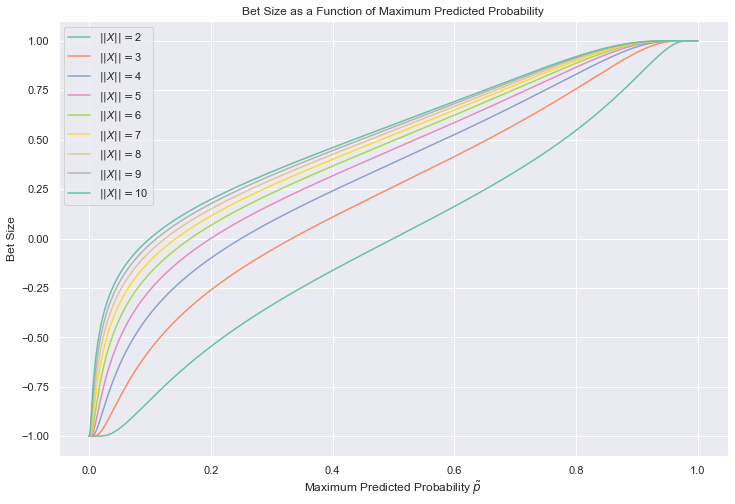

In [15]:
p = np.linspace(0, 1, 1000)
fig, ax = plt.subplots(figsize=(12, 8))
for X_size in range(2, 11):
    z = (p - 1 / X_size) / (p * (1 - p)) ** 0.5
    ax.plot(p, 2 * norm.cdf(z) - 1, label=f'$||X||=${X_size}')
ax.set_xlabel(r'Maximum Predicted Probability $\tilde{p}$')
ax.set_ylabel('Bet Size')
ax.legend(loc='best')
ax.set_title('Bet Size as a Function of Maximum Predicted Probability')
plt.show()

### 2. Bet Sizes & t1

As all the probabilities are between $0.5$ and $1$, we have to manually choose some positions to be short (otherwise they are all long). Let's choose every second position to be short. First we create a series of bet sizes for each of 10000 dates:

In [164]:
preds = np.random.uniform(0.5, 1.0, size=10000)
sides = np.array([(-1) ** i for i in range(10000)])
z = (preds - 0.5) / (preds * (1 - preds)) ** 0.5
bet_size = pd.Series(data=sides * (2 * norm.cdf(z) - 1), index=pd.date_range(start='1/1/1990', periods=10000))
bet_size

1990-01-01    0.057322
1990-01-02   -0.943288
1990-01-03    0.327755
1990-01-04   -0.569561
1990-01-05    0.380620
                ...   
2017-05-14   -0.520364
2017-05-15    0.856712
2017-05-16   -0.048810
2017-05-17    0.365394
2017-05-18   -0.020484
Freq: D, Length: 10000, dtype: float64

Now we obtain random shifts to create the `t1` series and cpmbine it with bets:

In [165]:
shifts = np.random.uniform(1, 25, size=10000).astype(int)
shifts = pd.Series(data=shifts * timedelta(days=1) + pd.date_range(start='1/1/1990', periods=10000),
                   index=pd.date_range(start='1/1/1990', periods=10000))
signals = shifts.to_frame(name='t1')
signals['signal'] = bet_size
signals.head()

,t1,signal
1990-01-01,1990-01-25,0.057322
1990-01-02,1990-01-16,-0.943288
1990-01-03,1990-01-17,0.327755
1990-01-04,1990-01-13,-0.569561
1990-01-05,1990-01-12,0.380620


Finally, we can calculate the average signal among those active:

In [166]:
avg_signals = avg_active_signals(signals)
avg_signals

1990-01-01    0.057322
1990-01-02   -0.442983
1990-01-03   -0.186070
1990-01-04   -0.281943
1990-01-05   -0.149431
                ...   
2017-05-27    0.426650
2017-05-28    0.538434
2017-06-01    0.734182
2017-06-06    0.365394
2017-06-10    0.000000
Length: 10009, dtype: float64

### 3. Concurrent Bets

Maximum number of concurrent long and short bets:

In [187]:
def get_num_conc_bets_by_date(date: Timestamp, signals: pd.DataFrame) -> Tuple[int, int]:
    '''
    Derives number of long and short concurrent bets by given date.
    
        Parameters:
            date (Timestamp): date of signal
            signals (pd.DataFrame): dataframe with signals
            
        Returns:
            long, short (Tuple[int, int]): number of long and short concurrent bets
    '''
    long, short = 0, 0
    for ind in pd.date_range(start=max(signals.index[0], date - timedelta(days=25)), end=date):
        if ind <= date and signals.loc[ind]['t1'] >= date:
            if signals.loc[ind]['signal'] >= 0:
                long += 1
            else:
                short += 1
    return long, short

In [168]:
for ind in signals.index:
    signals.loc[ind, 'conc_long'], signals.loc[ind, 'conc_short'] = get_num_conc_bets_by_date(date=ind, signals=signals)
signals

,t1,signal,conc_long,conc_short
1990-01-01,1990-01-25,0.057322,1.0,0.0
1990-01-02,1990-01-16,-0.943288,1.0,1.0
1990-01-03,1990-01-17,0.327755,2.0,1.0
1990-01-04,1990-01-13,-0.569561,2.0,2.0
1990-01-05,1990-01-12,0.380620,3.0,2.0
...,...,...,...,...
2017-05-14,2017-05-18,-0.520364,5.0,6.0
2017-05-15,2017-06-06,0.856712,6.0,6.0
2017-05-16,2017-06-01,-0.048810,6.0,6.0
2017-05-17,2017-06-10,0.365394,6.0,6.0


In [169]:
max_conc_long = signals['conc_long'].max()
max_conc_short = signals['conc_short'].max()

print(f'Maximum number of concurrent long bets: {max_conc_long}')
print(f'Maximum number of concurrent short bets: {max_conc_short}')

Maximum number of concurrent long bets: 12.0
Maximum number of concurrent short bets: 12.0


Now we can derive the bet size another way - using the formula
$$m_t=c_{t, l}\dfrac{1}{\overline{c}_l}-c_{t, s}\dfrac{1}{\overline{c}_s}$$

In [174]:
signals['bet_size'] = signals['conc_long'] / max_conc_long - signals['conc_short'] / max_conc_short
signals.head(5)

,t1,signal,conc_long,conc_short,bet_size
1990-01-01,1990-01-25,0.057322,1.0,0.0,0.083333
1990-01-02,1990-01-16,-0.943288,1.0,1.0,0.000000
1990-01-03,1990-01-17,0.327755,2.0,1.0,0.083333
1990-01-04,1990-01-13,-0.569561,2.0,2.0,0.000000
1990-01-05,1990-01-12,0.380620,3.0,2.0,0.083333


In [186]:
print(f'Max bet size: {signals.bet_size.max()}')
print(f'Min bet size: {signals.bet_size.min()}')

Max bet size: 0.5833333333333334
Min bet size: -0.6666666666666667


### 4. Bet Sizes Using Mixture of Two Gaussians

In [191]:
c = signals['conc_long'] - signals['conc_short']
c

1990-01-01    1.0
1990-01-02    0.0
1990-01-03    1.0
1990-01-04    0.0
1990-01-05    1.0
             ... 
2017-05-14   -1.0
2017-05-15    0.0
2017-05-16    0.0
2017-05-17    0.0
2017-05-18    0.0
Freq: D, Length: 10000, dtype: float64

Now we have to fit a mixture of two Gaussians on this series:

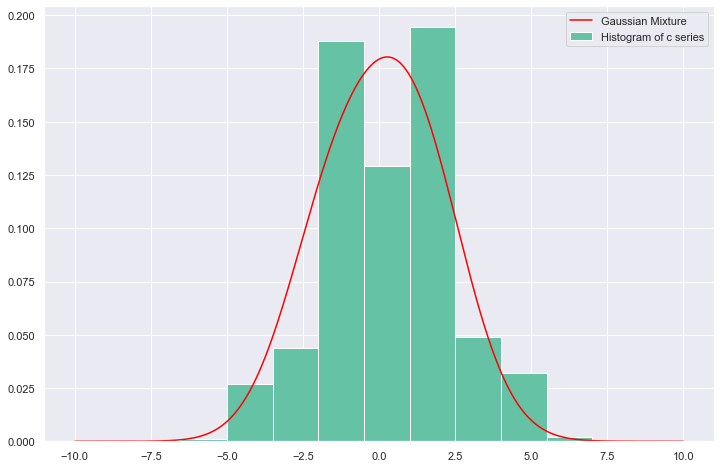

In [253]:
mixture = GaussianMixture(n_components=2).fit(c.values.reshape(-1, 1))
fig, ax = plt.subplots(figsize=(12, 8))
x = np.linspace(-10, 10, 1000).reshape(-1, 1)
logprob = mixture.score_samples(x)
pdf = np.exp(logprob)
ax.plot(x, pdf, color='red', label='Gaussian Mixture')
ax.hist(c.values, density=True, label='Histogram of c series')
ax.legend(loc='best')
plt.show()

Note: this is indeed a **mixture** of 2 Gaussians, though they have close means and so it's hard to distinguish components by looking at the graphics.

Now we have to be able to calculate CDF of the fitted Gaussian mixture. We can calculate it simply as a cumulative sum of its PDF.

In [268]:
x0 = np.linspace(-15, 0, 1000).reshape(-1, 1)
logprob = mixture.score_samples(x0)
F_0 = np.exp(logprob).sum() * 15 / 1000    # have to normalize pdf
for ind in signals.index:
    x1 = np.linspace(-15, c[ind], 1000).reshape(-1, 1)
    logprob = mixture.score_samples(x1)
    F_c = np.exp(logprob).sum() * (c[ind] + 15) / 1000
    if c[ind] >= 0:
        signals.loc[ind, 'bet_size_GM'] = (F_c - F_0) / (1 - F_0)
    else:
        signals.loc[ind, 'bet_size_GM'] = (F_c - F_0) / F_0

signals

,t1,signal,conc_long,conc_short,bet_size,bet_size_GM
1990-01-01,1990-01-25,0.057322,1.0,0.0,0.083333,0.345229
1990-01-02,1990-01-16,-0.943288,1.0,1.0,0.000000,0.000000
1990-01-03,1990-01-17,0.327755,2.0,1.0,0.083333,0.345229
1990-01-04,1990-01-13,-0.569561,2.0,2.0,0.000000,0.000000
1990-01-05,1990-01-12,0.380620,3.0,2.0,0.083333,0.345229
...,...,...,...,...,...,...
2017-05-14,2017-05-18,-0.520364,5.0,6.0,-0.083333,-0.354456
2017-05-15,2017-06-06,0.856712,6.0,6.0,0.000000,0.000000
2017-05-16,2017-06-01,-0.048810,6.0,6.0,0.000000,0.000000
2017-05-17,2017-06-10,0.365394,6.0,6.0,0.000000,0.000000


We can notice that bet sizes according to Gaussian mixture and method using concurrent bets agree on the side of the bet. However, GM produces bigger absolute bets meaning higher confidence in each bet.